In [1]:
import tensorflow as tf
tf.enable_eager_execution(
    config=None,
    device_policy=None,
    execution_mode=None
)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow_probability as tfp
import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.model_selection import train_test_split
import pandas as pd 
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class Train:
    def __init__(self, model, epochs, batch_size,validation_data):
        self.model = model
        self.batch_size = batch_size
        self.epochs = epochs
        self.validation_data=validation_data
        self.lik_loss = []
        self.kl_loss = []
        self.loss = []

    def fit(self, x_train, y_train,validation_data):

        for i in tqdm.tqdm(range(self.epochs)):
            model.fit(x_train, y_train,
                      epochs=1,
                      batch_size=self.batch_size,
                      validation_data=validation_data,
                      verbose = 0)

            KL = 0
            for layer in self.model.layers[:-1]:
                KL = KL + kl_loss_weight*tfp.distributions.kl_divergence(layer._posterior(np.ones(layer.input_shape[1])),
                                                layer._prior(np.ones(layer.input_shape[1]))).numpy()    #.numpy()


            self.loss.append(self.model.history.history['loss'])
            self.lik_loss.append(self.model.history.history['loss'])
            self.kl_loss.append(KL)

        return model

    def plot1(self):
        self.color1 = 'tab:red'
        self.color2 = 'tab:blue'
        plt.plot(self.lik_loss, label='likelihood loss', color=self.color1)
        plt.plot(self.kl_loss, label='KL loss', color=self.color2)
        plt.legend
        plt.ylim((-100,200))
        plt.legend()
        plt.show()
###class end

def neg_log_likelihood(y_true, y_pred, sigma=0.1):
	return K.sum(-y_pred.log_prob(y_true))

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(0.2))   #c=ln(e^0.2 -1)
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=0.2),
            reinterpreted_batch_ndims=1)),
    ])


In [2]:
data=pd.read_csv("power1.csv")
#data.iloc[0:2,8]  # ',' 前的部分标明选取的行，‘,’后的部分标明选取的列
x=data.iloc[:,1:-1]  #第一个：表示取所有行，除去第一列和最后一列
y=data.iloc[:,[-1]]  #提取最后一列
#划分数据集
#数据已打乱，train:test:validation=8:1:1
x_train_validation=data.iloc[648:1296,1:-1]
y_train_validation=data.iloc[648:1296,[-1]]
x_test1=data.iloc[1296:1320,1:-1] #2.24日数据
y_test1=data.iloc[1296:1320,[-1]]
x_train1,x_validation1, y_train1, y_validation1 = train_test_split(x_train_validation,y_train_validation,test_size = 0.2,random_state = 0,shuffle=True)

print(type(x))
print(type(x_train1))

x_train=np.array(x_train1)
x_test=np.array(x_test1)
x_validation=np.array(x_validation1)
y_train=np.array(y_train1)
y_test=np.array(y_test1)
y_validation=np.array(y_validation1)
print(type(x_test))
print(x_test.shape)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(24, 3)


In [3]:
# Mixture prior parameters shared across DenseVariational layer instances
# prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)
train_size=len(x_train)
batch_size = 16
num_batches = train_size / batch_size 
kl_loss_weight = 1.0 / num_batches
#kl_loss_weight = 1.0
# print(train_size,num_batches,kl_loss_weight)

    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(-2.2521684610440906+t[..., 1:]))),

In [4]:



# Build model.
c = np.log(np.expm1(0.1))
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tfp.layers.DenseVariational(units=9,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu',name="Dense_1"),
    tfp.layers.DenseVariational(units=9,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu',name="Dense_2"),
    tfp.layers.DenseVariational(units=2,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                name="Dense_3"),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3+tf.math.softplus(0.01*t[..., 1:]))),
])



#我们可以调整此模型以适合数据，方法是最大化标签的概率，或者等效地最小化负对数似然损失：-log P(y | x).   loss=neg_log_likelihood
model.compile(loss=neg_log_likelihood, optimizer=Adam(lr=0.02), metrics=['mse'])  #metrics: 列表，包含评估模型在训练和测试时的性能的指标

trainer = Train(model, 2000,16,validation_data=(x_validation,y_validation))     # Train(model, epochs, batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (DenseVariational)   (None, 9)                 108       
_________________________________________________________________
Dense_2 (DenseVariational)   (None, 9)                 270       
_________________________________________________________________
Dense_3 (DenseVariational)   (None, 2)                 60        
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 438
Trainable params: 438
Non-trainable params: 0
_________________________________________________________________


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:31<00:00,  7.36it/s]


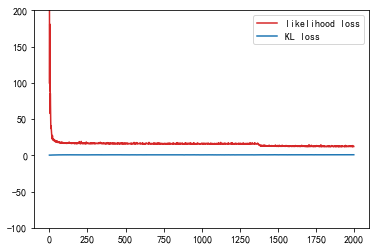

In [5]:
model = trainer.fit(x_train,y_train,validation_data=(x_validation,y_validation)) # 添加了测试集

# model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=0)
trainer.plot1()

In [6]:
#查看 W，b
weight_Dense_1,bias_Dense_1 = model.get_layer('Dense_1').get_weights()
print(weight_Dense_1.shape)

(72,)


In [7]:
#X_test = np.linspace(-1.5, 1.5, 100).reshape(-1, 1)
y_pred_list = []
y_pred_means = []
y_pred_stds = []
x_line=np.arange(24)
for i in tqdm.tqdm(range(100)):  #增大range(100)改进不大
    y_pred = model(x_test)
    y_pred_means.append(y_pred.mean())
    y_pred_stds.append(y_pred.stddev())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.24it/s]


y_pred_means: (100, 24, 1) y_pred_stds: (100, 24, 1)
y_means: (24, 100)
mean_means: (24,)


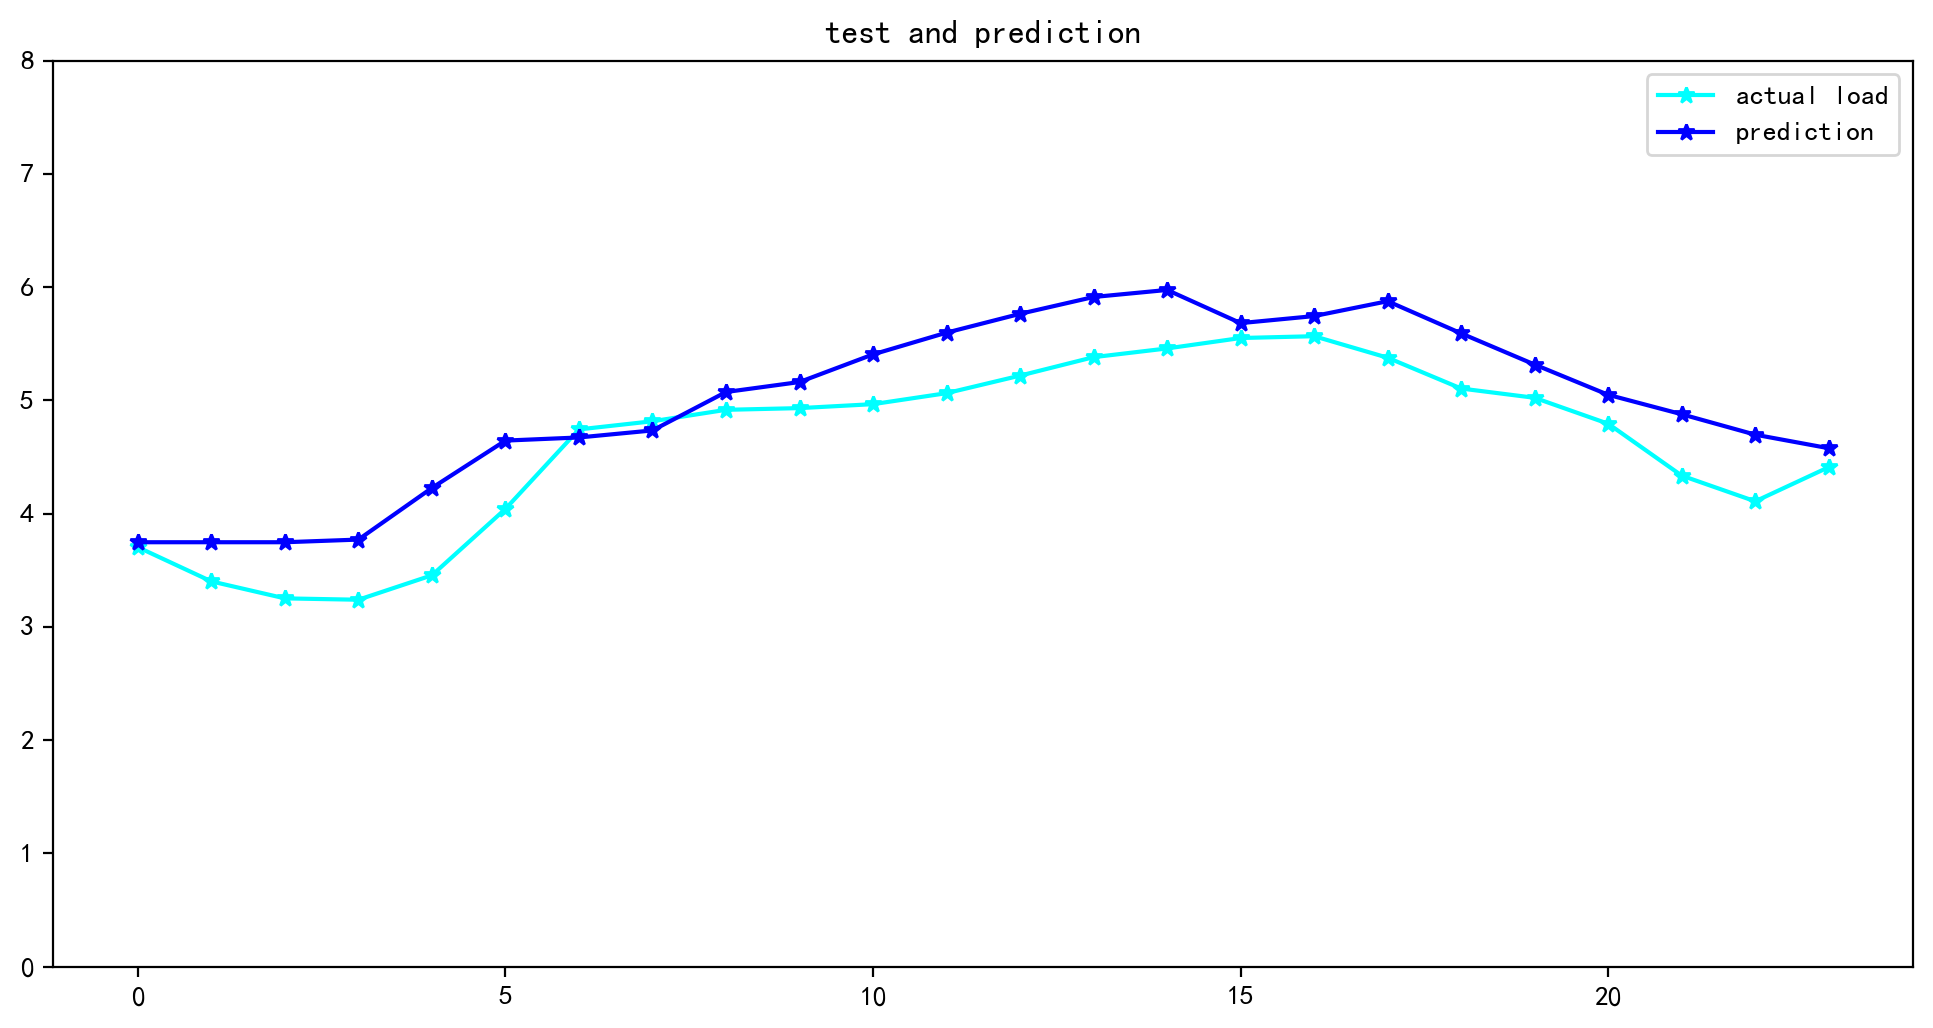

In [8]:
 
print("y_pred_means:",np.array(y_pred_means).shape ,"y_pred_stds:",np.array(y_pred_stds).shape) #查看List的维度需要将List转换成numpy数组
#plt.plot(X_test,y_pred_means)

y_means = np.concatenate(y_pred_means, axis=1)   # np.concatenate((a,b),axis=1)  #axis=1表示对a,b行的数组进行拼接
print("y_means:",np.array(y_means).shape)
mean_mean = np.mean(y_means, axis=1)#按行求均值,会降维
print("mean_means:",np.array(mean_mean).shape)
mean_sigma = np.std(y_means, axis=1)

fig=plt.figure(figsize=(12, 6),dpi=200)
plt.title('test and prediction') 
plt.ylim((0, 8))
plt.plot(x_line, y_test, color='cyan', label='actual load',marker='*')
plt.plot(x_line,mean_mean, 'b', label='prediction',marker='*')#'b'指：color='blue'
plt.legend()  #显示上面的label
plt.show()


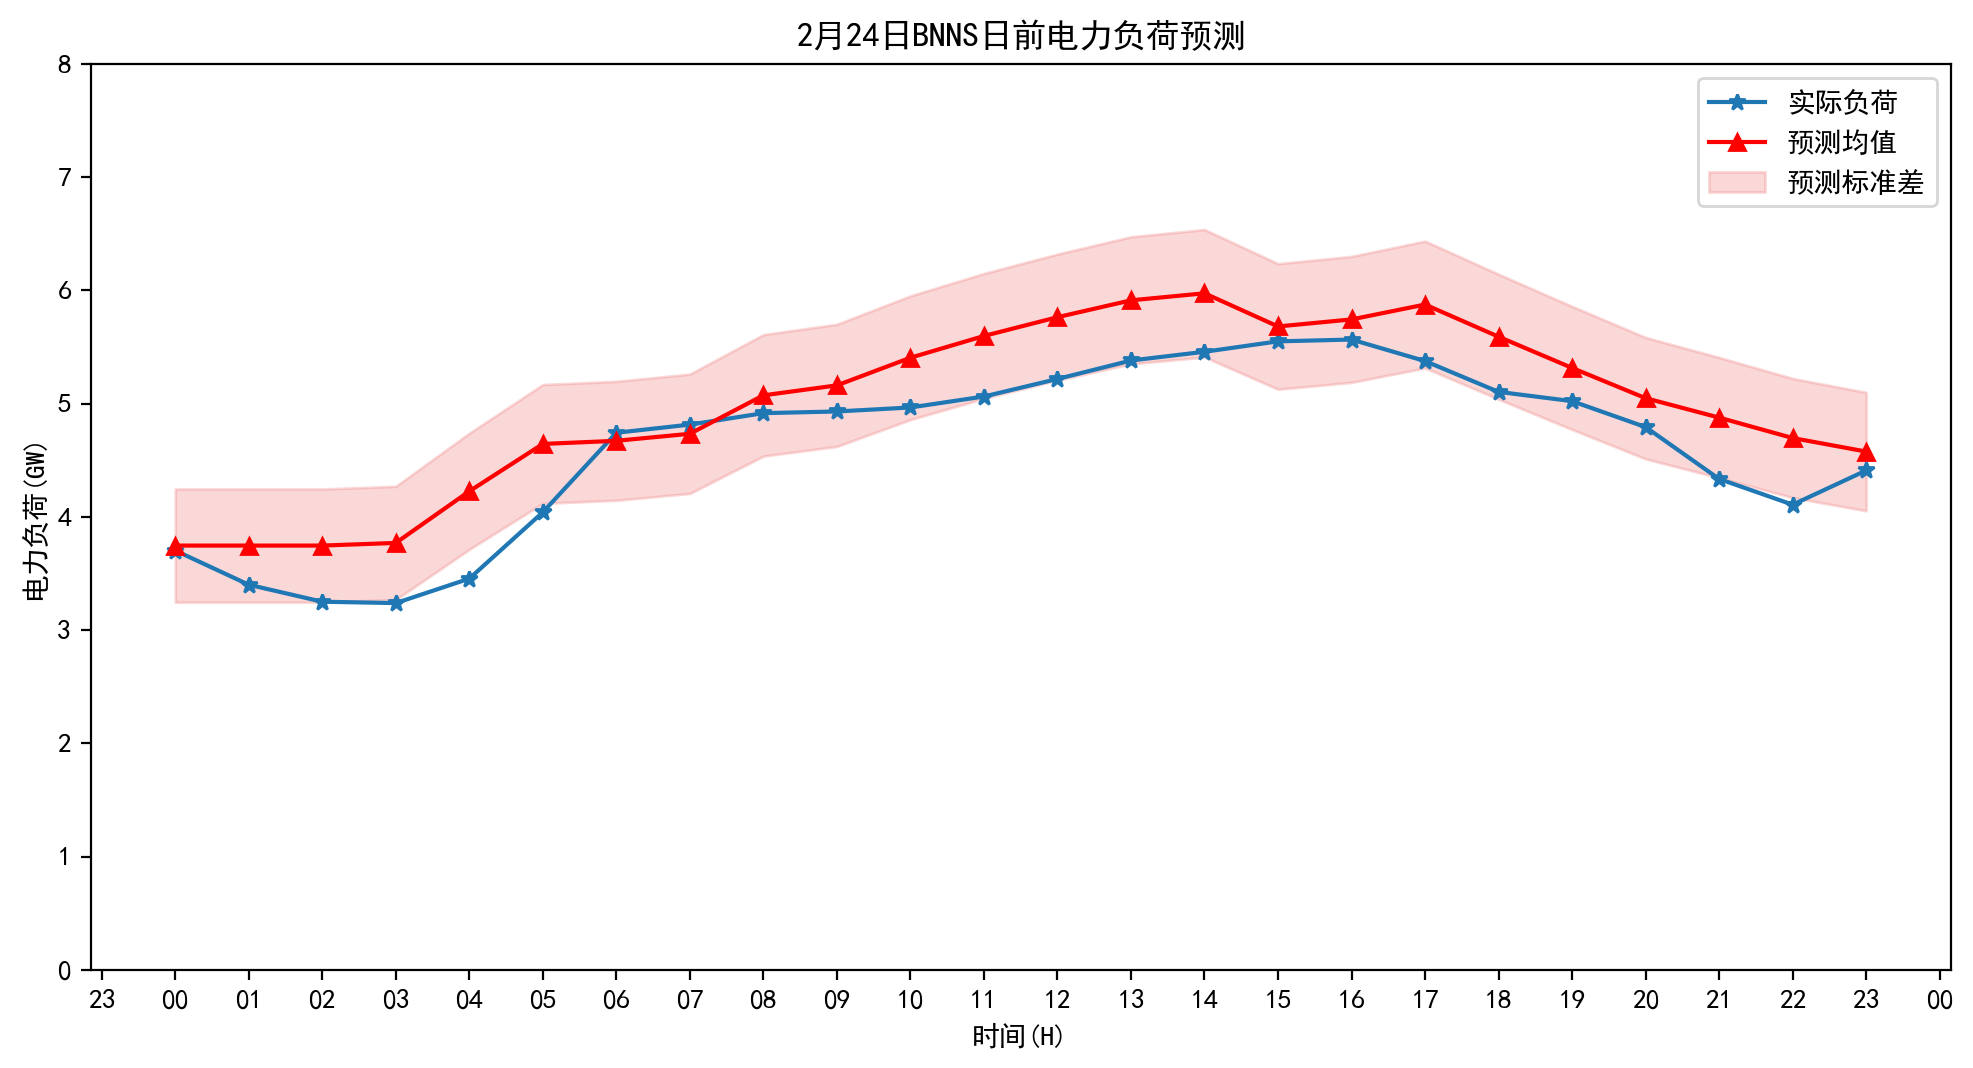

In [9]:
test_dates = np.arange('2014-02-24', '2014-02-25', dtype='datetime64[h]')
test_loc=mdates.HourLocator()
test_fmt=mdates.DateFormatter('%H')
y_test_stds = np.concatenate(y_pred_stds, axis=1)   # np.concatenate((a,b),axis=1)  #axis=1表示对a,b行的数组进行拼接
test_mean=mean_mean
test_stds=np.mean(y_test_stds, axis=1)

fig=plt.figure(figsize=(12, 6),dpi=200)
ax = fig.add_subplot(1,1,1)
ax.fill_between(test_dates,
                test_mean-test_stds,
                test_mean+test_stds,
                color='lightcoral', alpha=0.3,label=u'预测标准差')
ax.plot(test_dates,y_test,label='实际负荷',marker='*')
ax.plot(test_dates, test_mean, 'r-', label='预测均值',marker='^');
plt.title('2月24日BNNS日前电力负荷预测')
ax.xaxis.set_major_locator(test_loc)
ax.xaxis.set_major_formatter(test_fmt)
ax.set_ylabel("电力负荷(GW)")
ax.set_xlabel("时间(H)")
plt.legend()
plt.ylim((0,8))
plt.show()

In [10]:
print(test_mean)
print(y_test)
print(test_stds)

[3.7467768 3.7467768 3.7467768 3.770146  4.226353  4.6443043 4.6718316
 4.7339897 5.073257  5.161394  5.4054046 5.597458  5.7635326 5.9122868
 5.9744453 5.6815577 5.743716  5.875151  5.590923  5.315353  5.048444
 4.876791  4.6964784 4.5767837]
[[3.703]
 [3.401]
 [3.251]
 [3.239]
 [3.455]
 [4.041]
 [4.743]
 [4.815]
 [4.916]
 [4.931]
 [4.966]
 [5.063]
 [5.218]
 [5.381]
 [5.458]
 [5.55 ]
 [5.566]
 [5.376]
 [5.104]
 [5.022]
 [4.793]
 [4.335]
 [4.108]
 [4.41 ]]
[0.49949315 0.49949315 0.49949315 0.5001608  0.51271874 0.5243495
 0.525126   0.5268837  0.5365566  0.5390919  0.5461585  0.5517701
 0.55665797 0.56106395 0.5629132  0.5542423  0.5560743  0.559963
 0.5515806  0.5435453  0.53584826 0.53094274 0.5258271  0.52245253]


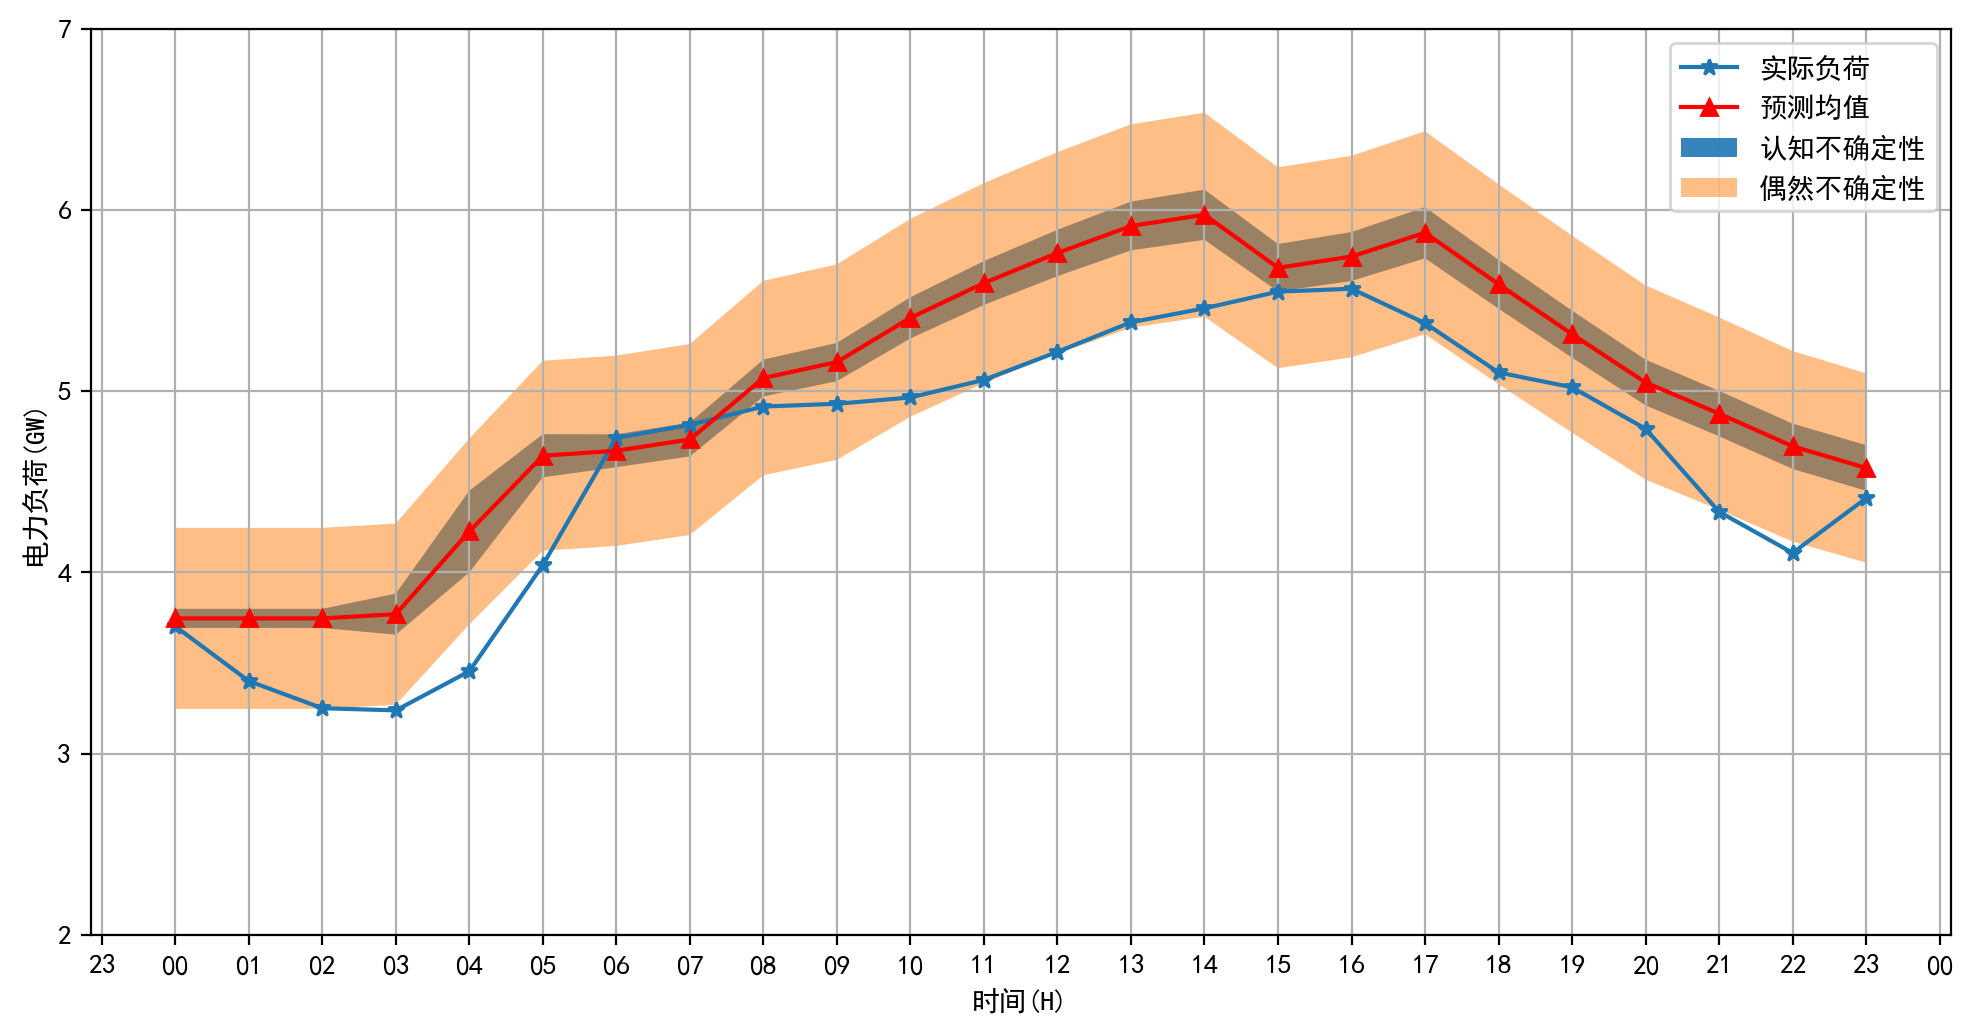

In [11]:
y_stds = np.concatenate(y_pred_stds, axis=1)
std_mean = np.mean(y_stds, axis=1) #Aleatoric uncertainty
std_sigma = np.std(y_stds, axis=1)
fig=plt.figure(figsize=(12, 6),dpi=200)
ax = fig.add_subplot(1,1,1)
ax.fill_between(test_dates,
                 mean_mean + 2*mean_sigma,
                 mean_mean - 2*mean_sigma,
                 alpha=0.9, label='认知不确定性')
ax.fill_between(test_dates,    
                 mean_mean + std_mean,  # Aleatoric uncertainty 条件均值的方差
                 mean_mean - std_mean,
                 alpha=0.5, label='偶然不确定性')
ax.plot(test_dates,y_test,label='实际负荷',marker='*')
ax.plot(test_dates, test_mean, 'r-', label='预测均值',marker='^');
#plt.title('2月24日BNNS日前电力负荷预测不确定性表示')
ax.xaxis.set_major_locator(test_loc)
ax.xaxis.set_major_formatter(test_fmt)
ax.set_ylabel("电力负荷(GW)")
ax.set_xlabel("时间(H)")
plt.legend()
plt.ylim((2,7))
plt.grid()
plt.show()

In [12]:
print('偶然不确定性:',std_mean)
print('认知不确定性:',mean_sigma)

print('偶然不确定性:',np.mean(std_mean))
print('认知不确定性:',np.mean(mean_sigma))

偶然不确定性: [0.49949315 0.49949315 0.49949315 0.5001608  0.51271874 0.5243495
 0.525126   0.5268837  0.5365566  0.5390919  0.5461585  0.5517701
 0.55665797 0.56106395 0.5629132  0.5542423  0.5560743  0.559963
 0.5515806  0.5435453  0.53584826 0.53094274 0.5258271  0.52245253]
认知不确定性: [0.02637218 0.02637218 0.02637218 0.05675687 0.11271442 0.05946408
 0.04541862 0.04663216 0.05093043 0.05279401 0.05688414 0.06054876
 0.06399681 0.06728961 0.06922692 0.06555209 0.06751286 0.07058535
 0.06741913 0.06490621 0.0630637  0.06265574 0.06246536 0.06297387]
偶然不确定性: 0.53426695
认知不确定性: 0.058704484


 
print("y_pred_means:",np.array(y_pred_means).shape ,"y_pred_stds:",np.array(y_pred_stds).shape) #查看List的维度需要将List转换成numpy数组
#plt.plot(X_test,y_pred_means)

y_means = np.concatenate(y_pred_means, axis=1)   # np.concatenate((a,b),axis=1)  #axis=1表示对a,b行的数组进行拼接
print("y_means:",np.array(y_means).shape)
mean_mean = np.mean(y_means, axis=1)#按行求均值,会降维
print("mean_means:",np.array(mean_mean).shape)
mean_sigma = np.std(y_means, axis=1)

plt.plot(X_test,y_means)
plt.show()
plt.plot(X_test,mean_mean)
plt.show()

y_stds = np.concatenate(y_pred_stds, axis=1)
std_mean = np.mean(y_stds, axis=1)
std_sigma = np.std(y_stds, axis=1)
plt.fill_between(X_test.ravel(),
                 mean_mean + mean_sigma,
                 mean_mean - mean_sigma,
                 alpha=0.3, label='Epistemic uncertainty')
plt.fill_between(X_test.ravel(),
                 mean_mean + std_mean,
                 mean_mean - std_mean,
                 alpha=0.3, label='Aleatoric uncertainty')
plt.plot(X_test, mean_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.title('Prediction')
plt.legend()
plt.ylim((-2,2))
plt.show()